In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil

from PIL import Image
from sklearn.metrics import mean_squared_error

## Contexto

El repositorio (https://www.kaggle.com/datasets/truthisneverlinear/childrens-dental-panoramic-radiographs-dataset?datasetId=3480288) contiene imagenes de diagnóstico de enfermedades orales distribuidos en los siguientes grupos:

- **Adult tooth segmentation dataset:** 4012 imagenes
- **Childrens dental caries segmentation dataset:** 386 imagenes
- **Pediatric dental disease detection dataset:** 100 imagenes

En total el repositorio contiene **4498 imagenes** y ocupa **2.07 Gb** de espacio en disco

Al interior de cada folder, encontramos imagenes en formato **png**, **jpg** y **bmp**, en algunos casos separadas para entrenamiento y prueba. Además también podemos encontrar imagenes llamadas máscaras para las cuales ya se ha realizado un procesamiento previo eliminando ruido y para las que finalmente se resaltan aún más la forma de los dientes y sus raíces.  

Por último, también el repositorio de imagenes contiene archivos en formato json con información y etiquetado que un sistema previo realizó a partir de las radiografías originales.  Estos no los considerams relevantes para el propósito de este proyecto.

## Análisis exploratorio de los datos

Empezamos creando un dataframe con la ruta a cada archivo, su nombre y atributos de la imagen como son: el formato de imagen, sus dimensiones en pixeles, el tamaño que ocupa en disco expresado en bytes y la dimensionalidad o bandas representadas por cada pixel.  Al tener estas propiedades dentro de un DataFrame se facilitarán algunas operaciones más adelante, así como la obtención de algunas estadísticas.

In [23]:
def get_files_info(root_folder):
    data = []

    for root, _, files in os.walk(root_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                image = Image.open(file_path)
                image_format = image.format
                width, height = image.size
                size_bytes = os.path.getsize(file_path)
                parent_folder = os.path.split(file_path)[0].split('\\')[1]
                rel_path = os.path.relpath(root, root_folder).replace(f'{parent_folder}\\', '')
                bands = len(image.getbands())
                
                data.append({
                    'full_path': file_path,
                    'main_folder': parent_folder,
                    'intermediate_path': rel_path,
                    'file_name': file,
                    'format': image_format,
                    'height': height,
                    'width': width,
                    'size': size_bytes, 
                    'bands': bands
                })

    return pd.DataFrame(data)

root_directory = 'Dental_dataset'
df = get_files_info(root_directory)
df

,full_path,main_folder,intermediate_path,file_name,format,height,width,size,bands
0,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Archive\images,1.png,PNG,942,2000,1448808,3
1,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Archive\images,10.png,PNG,942,2000,1321875,3
2,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Archive\images,100.png,PNG,942,2000,1323515,3
3,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Archive\images,101.png,PNG,942,2000,1264173,3
4,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Archive\images,102.png,PNG,942,2000,1206829,3
...,...,...,...,...,...,...,...,...,...
4493,Dental_dataset\Pediatric dental disease detect...,Pediatric dental disease detection dataset,Train\images,cate5_009.png,PNG,942,2000,1014949,3
4494,Dental_dataset\Pediatric dental disease detect...,Pediatric dental disease detection dataset,Train\images,cate5_010.png,PNG,942,2000,1024874,3
4495,Dental_dataset\Pediatric dental disease detect...,Pediatric dental disease detection dataset,Train\images,cate5_011.png,PNG,942,2000,849100,3
4496,Dental_dataset\Pediatric dental disease detect...,Pediatric dental disease detection dataset,Train\images,cate5_012.png,PNG,942,2000,1069663,3


In [32]:
def get_random_images(filter, images_to_display):
    filas_aleatorias = df[df['main_folder'] == filter].sample(n=images_to_display, random_state=random.seed())

    # Crear un subplot de tres columnas en una sola fila
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Iterar a través de las filas aleatorias y mostrar las imágenes en el subplot
    for i, (_, fila) in enumerate(filas_aleatorias.iterrows()):
        ruta_imagen = fila['full_path']
        imagen = Image.open(ruta_imagen)
        
        # Mostrar la imagen en el subplot
        axs[i].imshow(imagen)
        axs[i].set_title(f'Imagen {i+1}')
        axs[i].axis('off')  # Ocultar ejes

    plt.show()

### Ejemplos de imágenes de *Adult tooth segmentation dataset*

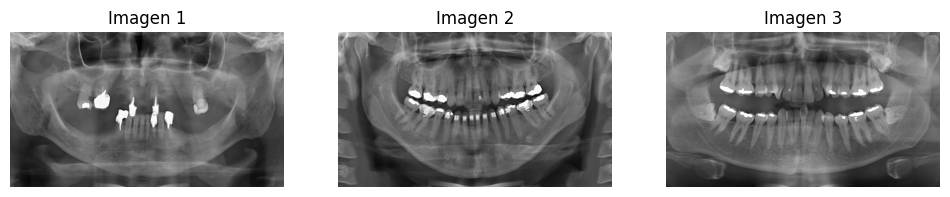

In [33]:
get_random_images('Adult tooth segmentation dataset', 3)

### Ejemplos de imágenes de *Childrens dental caries segmentation dataset*

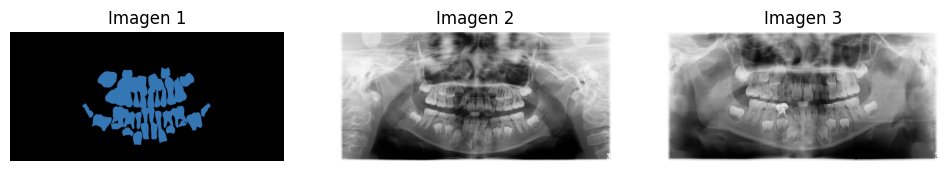

In [34]:

get_random_images('Childrens dental caries segmentation dataset', 3)

### Ejemplos de imágenes de *Pediatric dental disease detection dataset*

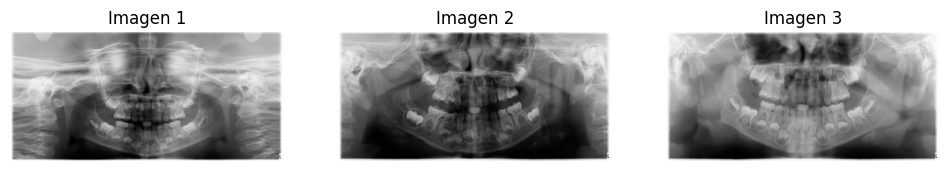

In [35]:
get_random_images('Pediatric dental disease detection dataset', 3)

In [24]:
df.describe()

,height,width,size,bands
count,4498.000000,4498.000000,4.498000e+03,4498.000000
mean,1048.278346,1994.829702,3.405525e+05,2.501556
std,91.478236,4.450293,4.113539e+05,0.865221
min,942.000000,1991.000000,1.905000e+03,1.000000
25%,942.000000,1991.000000,2.691125e+04,3.000000
50%,1127.000000,1991.000000,1.527135e+05,3.000000
75%,1127.000000,2000.000000,8.423295e+05,3.000000
max,1127.000000,2000.000000,2.821147e+06,3.000000


Vemos que: 

- La resolución de las imagenes se encuentran entre 942 x 1991 y entre 1127 X 2000 pixeles
- El tamaño que ocupa en disco está entre 15 Kb y 22 Mb con un promedio por imagen de 2.7 Mb, notando que en este aspecto la desviación estándar es bastante considerable.
- Para la inmensa mayoría de las imagenes, cada pixel está representando 3 dimensiones, es decir, los valores de RGB, esto quiere decir que a pesar que aunque a simple vista no se pueda notar una variedad de colores, las imágenes se están almacenando en color.

Al realizar un agrupamiento por el nombre de los archivos sin importar la jerarquía de folders, notamos que hay algunas imagenes que comparten el mismo nombre

In [3]:
file_names_count = df['file_name'].value_counts()
duplicated_images = pd.DataFrame(file_names_count[file_names_count >= 2]).rename(columns={'file_name': 'counts'}).reset_index().rename(columns={'index': 'file_name'})
duplicated_images

,file_name,counts
0,1.png,4
1,60.png,4
2,79.png,4
3,8.png,4
4,80.png,4
...,...,...
1373,cate4-00074.jpg,2
1374,cate4-00073.jpg,2
1375,cate4-00070.jpg,2
1376,cate4-00072.jpg,2


Verificamos algunas de ellas, son de dimensiones similares pero la diferencia en tamaño es considerable. Vale la pena revisar si son la misma imagen o si son diferentes para conservarlas y poder tener más imágenes disponibles para evaluar un futuro modelo.

Notamos que algunas corresponden a imagenes de máscaras (aquellas que contienen la palabra *mask* en la ruta del archivo) creadas a partir de las imagenes originales, por lo que las excluiremos junto con los archivos que no son de imagenes.

In [22]:
df.sort_values(by=['file_name'])

,full_path,main_folder,intermediate_path,file_name,format,height,width,size,bands
0,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Archive\images,1.png,PNG,942,2000,1448808,3
116,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Archive\mask,1.png,PNG,942,2000,10429,1
2816,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Panoramic radiography database\images,1.png,PNG,942,2000,878682,3
3414,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Panoramic radiography database\mask,1.png,PNG,942,2000,13386,3
117,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Archive\mask,10.png,PNG,942,2000,9784,1
...,...,...,...,...,...,...,...,...,...
2811,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Dataset and code\train\images,cate9-00041.jpg,JPEG,1127,1991,159331,3
2812,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Dataset and code\train\images,cate9-00042.jpg,JPEG,1127,1991,153311,3
2813,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Dataset and code\train\images,cate9-00043.jpg,JPEG,1127,1991,154982,3
2814,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Dataset and code\train\images,cate9-00044.jpg,JPEG,1127,1991,160879,3


Verificamos las otras que aún siguen repetidas.

In [5]:
df[~df['full_path'].str.contains('mask')].sort_values(by=['file_name']).head(10)

,full_path,main_folder,intermediate_path,file_name,format,height,width,size,bands
0,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Archive\images,1.png,PNG,942,2000,1448808,3
2816,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Panoramic radiography database\images,1.png,PNG,942,2000,878682,3
1,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Archive\images,10.png,PNG,942,2000,1321875,3
2817,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Panoramic radiography database\images,10.png,PNG,942,2000,980811,3
2,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Archive\images,100.png,PNG,942,2000,1323515,3
2818,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Panoramic radiography database\images,100.png,PNG,942,2000,979524,3
3,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Archive\images,101.png,PNG,942,2000,1264173,3
2819,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Panoramic radiography database\images,101.png,PNG,942,2000,877121,3
4,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Archive\images,102.png,PNG,942,2000,1206829,3
2820,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Panoramic radiography database\images,102.png,PNG,942,2000,847182,3


Formamos un nuevo DataFrame con las 2 rutas que apuntan al mismo archivo para identificar qué tan diferentes son.  El objetivo es solo dejar imagenes únicas.

In [6]:
df_no_mask = df[~df['full_path'].str.contains('mask')]
df_no_mask = df_no_mask[df_no_mask.duplicated(subset='file_name', keep=False)]
df_no_mask = df_no_mask.sort_values(by=['file_name'])

df_duplicated_even = df_no_mask.iloc[::2]
df_duplicated_odd = df_no_mask.iloc[1::2].reset_index()
df_duplicated_odd['full_path_duplicated'] = df_duplicated_even['full_path'].reset_index().full_path

In [7]:
df_duplicated_odd.head(5)

,index,full_path,main_folder,intermediate_path,file_name,format,height,width,size,bands,full_path_duplicated
0,2816,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Panoramic radiography database\images,1.png,PNG,942,2000,878682,3,Dental_dataset\Adult tooth segmentation datase...
1,2817,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Panoramic radiography database\images,10.png,PNG,942,2000,980811,3,Dental_dataset\Adult tooth segmentation datase...
2,2818,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Panoramic radiography database\images,100.png,PNG,942,2000,979524,3,Dental_dataset\Adult tooth segmentation datase...
3,2819,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Panoramic radiography database\images,101.png,PNG,942,2000,877121,3,Dental_dataset\Adult tooth segmentation datase...
4,2820,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Panoramic radiography database\images,102.png,PNG,942,2000,847182,3,Dental_dataset\Adult tooth segmentation datase...


Para proceder con la comparación de imágenes, es necesario convertirlas de RGB a escala de grises.

Creamos una función que tomará cada imagen original a partir de las rutas ya depuradas en pasos anteriores y las convertirá a una imagen en escala de grises, dejándolas en un folder temporal llamado *DentalDatasetGrayScale* pero manteniendo la jerarquía de los folders.

In [ ]:
def convert_to_grayscale(path, target):
    color_image = Image.open(path)
    gray_image = color_image.convert('L')
    target_path = path.replace('Dental_dataset', target)
    
    if not os.path.exists(os.path.dirname(target_path)):
        os.makedirs(os.path.dirname(target_path))

    gray_image.save(target_path)
    
[convert_to_grayscale(path, 'DentalDatasetGrayScale') for path in df_no_mask['full_path']]

In [9]:
# Ajustamos las rutas para apuntar al folder temporal
df_duplicated_odd['full_path'] = df_duplicated_odd['full_path'].str.replace('Dental_dataset', 'DentalDatasetGrayScale')
df_duplicated_odd['full_path_duplicated'] = df_duplicated_odd['full_path_duplicated'].str.replace('Dental_dataset', 'DentalDatasetGrayScale')
DentalDatasetGrayScale

,index,full_path,main_folder,intermediate_path,file_name,format,height,width,size,bands,full_path_duplicated
0,2816,DentalDatasetGrayScale\Adult tooth segmentatio...,Adult tooth segmentation dataset,Panoramic radiography database\images,1.png,PNG,942,2000,878682,3,DentalDatasetGrayScale\Adult tooth segmentatio...
1,2817,DentalDatasetGrayScale\Adult tooth segmentatio...,Adult tooth segmentation dataset,Panoramic radiography database\images,10.png,PNG,942,2000,980811,3,DentalDatasetGrayScale\Adult tooth segmentatio...
2,2818,DentalDatasetGrayScale\Adult tooth segmentatio...,Adult tooth segmentation dataset,Panoramic radiography database\images,100.png,PNG,942,2000,979524,3,DentalDatasetGrayScale\Adult tooth segmentatio...
3,2819,DentalDatasetGrayScale\Adult tooth segmentatio...,Adult tooth segmentation dataset,Panoramic radiography database\images,101.png,PNG,942,2000,877121,3,DentalDatasetGrayScale\Adult tooth segmentatio...
4,2820,DentalDatasetGrayScale\Adult tooth segmentatio...,Adult tooth segmentation dataset,Panoramic radiography database\images,102.png,PNG,942,2000,847182,3,DentalDatasetGrayScale\Adult tooth segmentatio...
...,...,...,...,...,...,...,...,...,...,...,...
689,4493,DentalDatasetGrayScale\Pediatric dental diseas...,Pediatric dental disease detection dataset,Train\images,cate5_009.png,PNG,942,2000,1014949,3,DentalDatasetGrayScale\Childrens dental caries...
690,4494,DentalDatasetGrayScale\Pediatric dental diseas...,Pediatric dental disease detection dataset,Train\images,cate5_010.png,PNG,942,2000,1024874,3,DentalDatasetGrayScale\Childrens dental caries...
691,4325,DentalDatasetGrayScale\Childrens dental caries...,Childrens dental caries segmentation dataset,Train\images,cate5_011.png,PNG,942,2000,985492,3,DentalDatasetGrayScale\Pediatric dental diseas...
692,4496,DentalDatasetGrayScale\Pediatric dental diseas...,Pediatric dental disease detection dataset,Train\images,cate5_012.png,PNG,942,2000,1069663,3,DentalDatasetGrayScale\Childrens dental caries...


Ahora creamos una función que recibirá la ruta de las dos imágenes a comparar, obtendremos un array de bytes de cada una y procedemos a calcular el error cuadrático medio entre las dos, resultando en una forma sencilla de obtener un valor que indique qué tan diferentes son las dos imágenes.

In [10]:
# Función para calcular el MSE entre dos imágenes
def calcular_mse(ruta_imagen1, ruta_imagen2):
    imagen1 = Image.open(ruta_imagen1)
    imagen2 = Image.open(ruta_imagen2)
    
    # Asegurarse de que ambas imágenes tengan el mismo tamaño
    if imagen1.size != imagen2.size:
        return None
    
    imagen1_array = np.array(imagen1)
    imagen2_array = np.array(imagen2)
    
    mse = mean_squared_error(imagen1_array, imagen2_array)
    return mse

# Calcular el MSE para cada par de imágenes en las columnas "full_path" y "full_path_duplicated"
df_duplicated_odd['MSE_score'] = df_duplicated_odd.apply(lambda row: calcular_mse(row['full_path'], row['full_path_duplicated']), axis=1)

In [17]:
df_duplicated_odd.MSE_score.describe()

count    694.000000
mean      31.594052
std       47.085743
min        0.000000
25%        0.000000
50%        0.000000
75%       98.590134
max      110.152848
Name: MSE_score, dtype: float64

Vemos que por encima del percentil 75% las imagenes son diferentes y deberíamos mantenerlas dentro de nuestro repositorio.  Las que se encuentran por debajo de ese percentil, son iguales porque el MSE que obtuvimos fue 0, por lo que debemos eliminar alguna de las dos comparadas.

In [12]:
df_duplicated_odd[df_duplicated_odd['MSE_score'] == 0]

,index,full_path,main_folder,intermediate_path,file_name,format,height,width,size,bands,full_path_duplicated,MSE_score
116,232,DentalDatasetGrayScale\Adult tooth segmentatio...,Adult tooth segmentation dataset,Dataset and code\test\images,cate1-00001.jpg,JPEG,1127,1991,98081,3,DentalDatasetGrayScale\Adult tooth segmentatio...,0.0
117,1317,DentalDatasetGrayScale\Adult tooth segmentatio...,Adult tooth segmentation dataset,Dataset and code\train\images,cate1-00002.jpg,JPEG,1127,1991,165101,3,DentalDatasetGrayScale\Adult tooth segmentatio...,0.0
118,234,DentalDatasetGrayScale\Adult tooth segmentatio...,Adult tooth segmentation dataset,Dataset and code\test\images,cate1-00003.jpg,JPEG,1127,1991,158490,3,DentalDatasetGrayScale\Adult tooth segmentatio...,0.0
119,235,DentalDatasetGrayScale\Adult tooth segmentatio...,Adult tooth segmentation dataset,Dataset and code\test\images,cate1-00004.jpg,JPEG,1127,1991,178800,3,DentalDatasetGrayScale\Adult tooth segmentatio...,0.0
120,236,DentalDatasetGrayScale\Adult tooth segmentatio...,Adult tooth segmentation dataset,Dataset and code\test\images,cate1-00005.jpg,JPEG,1127,1991,152442,3,DentalDatasetGrayScale\Adult tooth segmentatio...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
661,705,DentalDatasetGrayScale\Adult tooth segmentatio...,Adult tooth segmentation dataset,Dataset and code\test\images,cate4-00136.jpg,JPEG,1127,1991,162869,3,DentalDatasetGrayScale\Adult tooth segmentatio...,0.0
662,706,DentalDatasetGrayScale\Adult tooth segmentatio...,Adult tooth segmentation dataset,Dataset and code\test\images,cate4-00137.jpg,JPEG,1127,1991,166190,3,DentalDatasetGrayScale\Adult tooth segmentatio...,0.0
663,1906,DentalDatasetGrayScale\Adult tooth segmentatio...,Adult tooth segmentation dataset,Dataset and code\train\images,cate4-00138.jpg,JPEG,1127,1991,146486,3,DentalDatasetGrayScale\Adult tooth segmentatio...,0.0
664,708,DentalDatasetGrayScale\Adult tooth segmentatio...,Adult tooth segmentation dataset,Dataset and code\test\images,cate4-00139.jpg,JPEG,1127,1991,155941,3,DentalDatasetGrayScale\Adult tooth segmentatio...,0.0


Encontramos entonces que hay 478 imagenes en *Adult tooth segmentation dataset\Dataset and code\train\images*, que tienen una copia similar en *Adult tooth segmentation dataset\Dataset and code\test\images*, por lo que excluiremos del dataset estas duplicadas

In [13]:
df_cleaned = df_no_mask[~df_no_mask['full_path'].str.contains(r"Adult tooth segmentation dataset\\Dataset and code\\test\\images")]
df_cleaned

,full_path,main_folder,intermediate_path,file_name,format,height,width,size,bands
0,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Archive\images,1.png,PNG,942,2000,1448808,3
2816,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Panoramic radiography database\images,1.png,PNG,942,2000,878682,3
1,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Archive\images,10.png,PNG,942,2000,1321875,3
2817,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Panoramic radiography database\images,10.png,PNG,942,2000,980811,3
2,Dental_dataset\Adult tooth segmentation datase...,Adult tooth segmentation dataset,Archive\images,100.png,PNG,942,2000,1323515,3
...,...,...,...,...,...,...,...,...,...
4325,Dental_dataset\Childrens dental caries segment...,Childrens dental caries segmentation dataset,Train\images,cate5_011.png,PNG,942,2000,985492,3
4326,Dental_dataset\Childrens dental caries segment...,Childrens dental caries segmentation dataset,Train\images,cate5_012.png,PNG,942,2000,1009735,3
4496,Dental_dataset\Pediatric dental disease detect...,Pediatric dental disease detection dataset,Train\images,cate5_012.png,PNG,942,2000,1069663,3
4327,Dental_dataset\Childrens dental caries segment...,Childrens dental caries segmentation dataset,Train\images,cate5_013.png,PNG,942,2000,978345,3


Para el objetivo de nuestro proyecto moveremos todas las imagenes a un único folder las radiografías originales, sin tener en cuenta la jerarquía de folders original, y excluyendo las máscaras y los archivos .json.

In [14]:
def extract_images(source_paths, target_folder):
    # Crear el directorio de destino si no existe
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    
    for source_path in source_paths:
        target_filename = os.path.basename(source_path)
        target_path = os.path.join(target_folder, target_filename)
        
        # Si el archivo de destino ya existe, ajustamos el nombre del archivo agregando un número aleatorio al final del nombre
        # Estos archivos son diferentes y vale la pena conservarlos
        if os.path.exists(target_path):
            random_number = random.randint(1, 9999)
            file_name, file_extension = os.path.splitext(target_filename)
            target_filename = f"{file_name}_{random_number}{file_extension}"
            target_path = os.path.join(target_folder, target_filename)
        
        shutil.copy(source_path, target_path)


extract_images(df_cleaned['full_path'], 'DentalDatasetCleaned')

In [25]:
# Borramos el repositorio temporal llamado DentalDatasetGrayScale
def delete_folder(folder):
    if os.path.exists(folder):
        # Eliminar la carpeta y su contenido de manera recursiva
        shutil.rmtree(folder)
        print(f'Carpeta {folder} eliminada exitosamente.')
    else:
        print(f'La carpeta {folder} no existe.')

delete_folder('DentalDatasetGrayScale')

Carpeta DentalDatasetGrayScale eliminada exitosamente.


De esta manera redujimos el repositorio a 910 imágenes únicas.

In [15]:
# Conteo por dimensiones y formato
count_by_size = df_cleaned.groupby(['width', 'height', 'format']).size().reset_index(name='count')
count_by_size


,width,height,format,count
0,1991,1127,JPEG,478
1,2000,942,PNG,432


El 52% de las imagenes se encuentran en formato JEPG con una dimensión de 1991 x 1127 pixeles y el 48% restante corresponden a imagenes en formato PNG con una resolución de 2000 x 942 pixeles.

In [21]:
(df_cleaned['size']/1024).describe()

count     910.000000
mean      566.593434
std       451.925470
min        95.782227
25%       147.915039
50%       169.917969
75%       986.069336
max      1487.865234
Name: size, dtype: float64

Respecto al espacio en disco, el repositorio de imagenes con el que trabajaremos en adelante ocupa 505 Mb en diso, lo que facilitará la manipulación en fases posteriores del proyecto.